In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from enum import Enum
import random
import math
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

In [22]:
class SchedulingPolicy(Enum):
    RM = "Rate Monotonic"     
    EDF = "Earliest Deadline First"  
    FIFO = "First In First Out"     

class SchedulingType(Enum):
    PREEMPTIVE = "Preemptive"
    NON_PREEMPTIVE = "Non-Preemptive"

class SchedulingModel(Enum):
    PARTITIONED = "Partitioned"  
    GLOBAL = "Global"

class TaskAllocationPolicy(Enum):
    WFD = "Worst-Fit Decreasing"
    BFD = "Best-Fit Decreasing"
    FFD = "First-Fit Decreasing"
    ROUND_ROBIN = "Round-Robin"           

In [23]:
@dataclass
class Task:
    id: int
    period: float
    net: float  
    deadline: float
    priority: int
    arrival_time: float = 0.0
    core_id: int = 0

In [24]:
class RealTimeSystem:
    def __init__(self, num_cores: int = 4, scheduling_policy: SchedulingPolicy = SchedulingPolicy.RM,
                 scheduling_type: SchedulingType = SchedulingType.PREEMPTIVE,
                 scheduling_model: SchedulingModel = SchedulingModel.PARTITIONED,
                 task_allocation_policy: TaskAllocationPolicy = TaskAllocationPolicy.WFD):
        self.num_cores = num_cores
        self.scheduling_policy = scheduling_policy
        self.scheduling_type = scheduling_type
        self.scheduling_model = scheduling_model
        self.task_allocation_policy = task_allocation_policy
        self.tasks: List[Task] = []
        self.analysis_results = {}
        self.core_assignments: Dict[int, List[int]] = {i: [] for i in range(num_cores)}
        
    def generate_task_set(self, num_tasks: int, target_utilization: float, 
                         period_range: Tuple[int, int] = (10, 100)) -> List[Task]:
        tasks = []
        utilizations = self._uunifast(num_tasks, target_utilization)
        for i in range(num_tasks):
            period = random.randint(period_range[0], period_range[1])
            net = utilizations[i] * period
            deadline = period
            
            if self.scheduling_policy == SchedulingPolicy.RM:
                priority = period  
            elif self.scheduling_policy == SchedulingPolicy.EDF:
                priority = deadline 
            else:  # FIFO
                priority = i  
            
            task = Task(
                id=i,
                period=period,
                net=net,
                deadline=deadline,
                priority=priority,
                arrival_time=0.0
            )
            tasks.append(task)
        
        tasks.sort(key=lambda t: t.priority)
        
        if self.scheduling_model == SchedulingModel.PARTITIONED:
            self._assign_tasks_to_cores_partitioned(tasks, self.task_allocation_policy)
        
        self.tasks = tasks
        return tasks
    
    def _assign_tasks_to_cores_partitioned(self, tasks: List[Task], 
                                           allocation_policy: TaskAllocationPolicy) -> None:

        self.core_assignments = {i: [] for i in range(self.num_cores)}
        core_utilizations = [0.0] * self.num_cores 

        tasks_sorted_by_util = sorted(tasks, key=lambda t: t.net / t.period, reverse=True)

        if allocation_policy == TaskAllocationPolicy.FFD:
            for task in tasks_sorted_by_util:
                task_utilization = task.net / task.period
                assigned = False
                for core_id in range(self.num_cores):
                    if core_utilizations[core_id] + task_utilization <= 1.0:
                        task.core_id = core_id
                        self.core_assignments[core_id].append(task.id)
                        core_utilizations[core_id] += task_utilization
                        assigned = True
                        break
                if not assigned:
                    task.core_id = 0 
                    self.core_assignments[task.core_id].append(task.id)
                    core_utilizations[task.core_id] += task_utilization


        elif allocation_policy == TaskAllocationPolicy.BFD:
            for task in tasks_sorted_by_util:
                task_utilization = task.net / task.period
                best_fit_core_id = -1
                min_remaining_capacity = float('inf') 
                
                for core_id in range(self.num_cores):
                    remaining_capacity = 1.0 - core_utilizations[core_id]
                    if remaining_capacity >= task_utilization: 
                        if remaining_capacity - task_utilization < min_remaining_capacity:
                            min_remaining_capacity = remaining_capacity - task_utilization
                            best_fit_core_id = core_id
                
                if best_fit_core_id != -1:
                    task.core_id = best_fit_core_id
                    self.core_assignments[best_fit_core_id].append(task.id)
                    core_utilizations[best_fit_core_id] += task_utilization
                else:
                    min_util_core = core_utilizations.index(min(core_utilizations))
                    task.core_id = min_util_core
                    self.core_assignments[min_util_core].append(task.id)
                    core_utilizations[min_util_core] += task_utilization


        elif allocation_policy == TaskAllocationPolicy.WFD:
            for task in tasks_sorted_by_util:
                task_utilization = task.net / task.period
                best_fit_core_id = -1
                max_remaining_capacity = -1.0 
                
                for core_id in range(self.num_cores):
                    remaining_capacity_before = 1.0 - core_utilizations[core_id]
                    if remaining_capacity_before >= task_utilization: 
                        if remaining_capacity_before - task_utilization > max_remaining_capacity:
                            max_remaining_capacity = remaining_capacity_before - task_utilization
                            best_fit_core_id = core_id
                
                if best_fit_core_id != -1:
                    task.core_id = best_fit_core_id
                    self.core_assignments[best_fit_core_id].append(task.id)
                    core_utilizations[best_fit_core_id] += task_utilization
                else:
                    min_util_core = core_utilizations.index(min(core_utilizations))
                    task.core_id = min_util_core
                    self.core_assignments[min_util_core].append(task.id)
                    core_utilizations[min_util_core] += task_utilization


        elif allocation_policy == TaskAllocationPolicy.ROUND_ROBIN:
            for i, task in enumerate(tasks): 
                core_id = i % self.num_cores
                task_utilization = task.net / task.period

                task.core_id = core_id
                self.core_assignments[core_id].append(task.id)
                core_utilizations[core_id] += task_utilization 
                
                if core_utilizations[core_id] > 1.0:
                    print(f"  Warning: Core {core_id} overutilized ({core_utilizations[core_id]:.2f}) by task {task.id} using Round-Robin.")

        else:
            raise ValueError(f"Unknown task allocation policy: {allocation_policy}")

        # After allocation, ensure tasks are sorted by their priority on their assigned cores.
        # This is critical for the _calculate_response_time_partitioned method.
        for core_id in self.core_assignments:
            self.core_assignments[core_id] = sorted(self.core_assignments[core_id], 
                                                    key=lambda task_id: next(t for t in tasks if t.id == task_id).priority)
            # Re-map task IDs to actual Task objects for easier access during response time calculation
            self.core_assignments[core_id] = [next(t for t in tasks if t.id == task_id) 
                                               for task_id in self.core_assignments[core_id]]

        # Update core_id in Task objects based on final assignments (already done in loops, but re-confirm)
        for core_id, assigned_tasks_on_core in self.core_assignments.items():
            for task_obj in assigned_tasks_on_core:
                task_obj.core_id = core_id
    
    def _uunifast(self, n: int, target_u: float) -> List[float]:
        if n == 1:
            return [target_u]
        
        utilizations = []
        sum_u = target_u
        
        for i in range(n - 1):
            next_sum_u = sum_u * (random.random() ** (1.0 / (n - i)))
            utilizations.append(sum_u - next_sum_u)
            sum_u = next_sum_u
        
        utilizations.append(sum_u)
        return utilizations
    
    def calculate_response_time_with_overrun(self, task_index: int, overrun_amount: float, interferer_overrun_factor: float = 0.0) -> float:
        if task_index >= len(self.tasks):
            return float('inf')
        
        task = self.tasks[task_index]
        
        if self.scheduling_model == SchedulingModel.PARTITIONED:
            return self._calculate_response_time_partitioned(task_index, overrun_amount, interferer_overrun_factor)
        else:  
            return self._calculate_response_time_global(task_index, overrun_amount, interferer_overrun_factor)
    
    def _calculate_response_time_partitioned(self, task_index: int, 
                                           overrun_amount: float, 
                                           interferer_overrun_factor: float) -> float: 

        task = self.tasks[task_index]
        
        core_tasks = self.core_assignments.get(task.core_id, []) 
        
        task_in_core_list = next((t for t in core_tasks if t.id == task.id), None)
        if task_in_core_list is None:
            return float('inf') 

        task_pos = core_tasks.index(task_in_core_list)
        
        Ci_plus_Delta_i = task.net + overrun_amount

        # Fixed-Priority (RM)
        if self.scheduling_policy == SchedulingPolicy.RM:
            if self.scheduling_type == SchedulingType.PREEMPTIVE:
                # P-FP / P-RM Formula: Ri(k+1) = Ci + Delta_i + Sum(ceil(Ri(k)/Tj) * (Cj + Delta_j))
                R = Ci_plus_Delta_i
                R_prev = 0.0
                max_iterations = 100
                iteration = 0
                
                while abs(R - R_prev) > 0.001 and iteration < max_iterations:
                    R_prev = R
                    interference = 0
                    for j in range(task_pos):  # Iterate over higher priority tasks
                        higher_priority_task = core_tasks[j]
                        Cj_plus_Delta_j = higher_priority_task.net + (higher_priority_task.net * interferer_overrun_factor)
                        num_preemptions = math.ceil(R / higher_priority_task.period)
                        interference += num_preemptions * Cj_plus_Delta_j
                    R = Ci_plus_Delta_i + interference
                    
                    if R > task.deadline:
                        return float('inf')
                    iteration += 1
                return R
                
            elif self.scheduling_type == SchedulingType.NON_PREEMPTIVE:
                # NP-FP / NP-RM Formula: Ri = Ji + Ci + Sum(Cj for hp) + Sum(Delta_j for lp)                
                blocking_term = 0.0
                lp_tasks = core_tasks[task_pos + 1:] # Tasks with lower priority
                if lp_tasks:
                    # Blocking is the maximum execution time (with overrun) of any lower priority task that could be executing when task 'i' arrives.
                    blocking_term = max((lp_t.net + (lp_t.net * interferer_overrun_factor)) for lp_t in lp_tasks)
                higher_priority_sum_Cj = sum(hp_t.net for hp_t in core_tasks[:task_pos])
                
                # Sum of Cj for higher priority tasks (their base NETs)
                sum_hp_Cj = sum(hp_t.net for hp_t in core_tasks[:task_pos])
                
                # Sum of Delta_j for lower priority tasks. This is unusual.
                # Interpreting Delta_j here as just their additional overrun, not total execution.
                sum_lp_Delta_j = sum((lp_t.net * interferer_overrun_factor) for lp_t in core_tasks[task_pos + 1:])
                R = blocking_term + task.net + sum_hp_Cj + sum_lp_Delta_j
                R = blocking_term + Ci_plus_Delta_i + sum_hp_Cj + sum_lp_Delta_j
                
                if R > task.deadline:
                    return float('inf')
                return R

        # Earliest Deadline First (EDF)
        elif self.scheduling_policy == SchedulingPolicy.EDF:
            if self.scheduling_type == SchedulingType.PREEMPTIVE:
                # P-EDF Formula: Ri = inf { t >= 0 | Sum_j (ceil((t - Dj)/Tj) * (Cj + Delta_j)) + Ci + Delta_i <= t }
                all_tasks_on_core = core_tasks 
                
                def g(t):
                    demand = 0.0
                    for other_task in all_tasks_on_core:
                        if other_task.id == task.id: # Current task
                            demand += Ci_plus_Delta_i
                        else: # Other tasks
                            Cj_plus_Delta_j = other_task.net + (other_task.net * interferer_overrun_factor)
                            num_instances = max(0, math.ceil((t - other_task.deadline) / other_task.period))
                            demand += num_instances * Cj_plus_Delta_j
                    return demand - t
                
                R = Ci_plus_Delta_i # Initial guess
                R_prev = 0.0
                iteration = 0
                max_iterations = 200 # Increased for EDF convergence
                
                while abs(R - R_prev) > 0.001 and iteration < max_iterations:
                    R_prev = R
                    interference = 0
                    for other_task in all_tasks_on_core:
                        if other_task.id == task.id:
                            continue
                        
                        Cj_plus_Delta_j = other_task.net + (other_task.net * interferer_overrun_factor)
                        num_instances = max(0, math.ceil((R - other_task.deadline) / other_task.period))
                        interference += num_instances * Cj_plus_Delta_j
                    
                    # R_new = Ci_plus_Delta_i + sum_for_EDF
                    current_demand_from_others = 0
                    for other_task in all_tasks_on_core:
                        if other_task.id == task.id:
                            continue
                        Cj_plus_Delta_j = other_task.net + (other_task.net * interferer_overrun_factor)
                        num_activations = math.ceil(R / other_task.period) 
                        current_demand_from_others += num_activations * Cj_plus_Delta_j
                    
                    demand_on_core = Ci_plus_Delta_i # Initial demand
                    for j in range(task_pos): # Iterate over higher priority tasks (earlier deadline)
                        hp_task = core_tasks[j]
                        Cj_plus_Delta_j = hp_task.net + (hp_task.net * interferer_overrun_factor)
                        # How many times does this higher priority task interfere within R?
                        num_preemptions = math.ceil(R / hp_task.period)
                        demand_on_core += num_preemptions * Cj_plus_Delta_j
                    
                    R = demand_on_core
                    
                    if R > task.deadline:
                        return float('inf')
                    iteration += 1
                return R
                
            elif self.scheduling_type == SchedulingType.NON_PREEMPTIVE:
                # NP-EDF Formula: Ri = Ji + Ci + Sum_ready(Cj + Delta_j)
                blocking_term = 0.0
                lp_tasks = core_tasks[task_pos + 1:]
                if lp_tasks:
                    blocking_term = max((lp_t.net + (lp_t.net * interferer_overrun_factor)) for lp_t in lp_tasks)
 
                sum_hp_ready = 0.0
                for hp_task in core_tasks[:task_pos]:
                    sum_hp_ready += hp_task.net + (hp_task.net * interferer_overrun_factor)
                    
                R = blocking_term + Ci_plus_Delta_i + sum_hp_ready
                
                if R > task.deadline:
                    return float('inf')
                return R

        # First-In First-Out (FIFO)
        elif self.scheduling_policy == SchedulingPolicy.FIFO:
            if self.scheduling_type == SchedulingType.PREEMPTIVE:
                # P-FIFO Formula: Ri = Ci + Sum_Queue(Cj + Delta_j)
                sum_queue_interference = 0.0
                for j in range(task_pos):
                    queued_task = core_tasks[j]
                    sum_queue_interference += queued_task.net + (queued_task.net * interferer_overrun_factor)
                
                R = Ci_plus_Delta_i + sum_queue_interference
                
                if R > task.deadline:
                    return float('inf')
                return R

            elif self.scheduling_type == SchedulingType.NON_PREEMPTIVE:
                # NP-FIFO Formula: Ri = Ji + Ci + Sum_j=1_to_i-1 (Cj + Delta_j)
                sum_preceding_tasks_execution = 0.0
                for j in range(task_pos):
                    preceding_task = core_tasks[j]
                    sum_preceding_tasks_execution += preceding_task.net + (preceding_task.net * interferer_overrun_factor)
                
                R = Ci_plus_Delta_i + sum_preceding_tasks_execution
                
                if R > task.deadline:
                    return float('inf')
                return R
        
        return float('inf') # Should not reach here
    
    def _calculate_response_time_global(self, task_index: int, overrun_amount: float, interferer_overrun_factor: float) -> float:
        
        task = self.tasks[task_index]
        
        Ci_plus_Delta_i = task.net + overrun_amount

        # Fixed-Priority (RM) - Global
        if self.scheduling_policy == SchedulingPolicy.RM:
            # The formula for P-FP is: Ri(k+1) = Ci + Delta_i + Sum(ceil(Ri(k)/Tj) * (Cj + Delta_j))
            # For global, this sum is usually divided by m.
            R = Ci_plus_Delta_i
            R_prev = 0.0
            max_iterations = 100
            iteration = 0
            
            # Higher priority tasks are self.tasks[:task_index]
            higher_priority_tasks_global = self.tasks[:task_index] # Assuming self.tasks is sorted by priority
            
            while abs(R - R_prev) > 0.001 and iteration < max_iterations:
                R_prev = R
                total_hp_workload = 0.0
                for hp_task in higher_priority_tasks_global:
                    Cj_plus_Delta_j = hp_task.net + (hp_task.net * interferer_overrun_factor)
                    num_preemptions = math.ceil(R / hp_task.period)
                    total_hp_workload += num_preemptions * Cj_plus_Delta_j
                
                # Global FP/RM interference is often approximated by (1/m) * total_workload
                interference_from_others = total_hp_workload / self.num_cores
                
                higher_priority_workload = 0
                for j in range(task_index): 
                    higher_priority_task = self.tasks[j]
                    if higher_priority_task.period < task.period: 
                        workload = math.ceil(R / higher_priority_task.period) * \
                                   (higher_priority_task.net + (higher_priority_task.net * interferer_overrun_factor))
                        higher_priority_workload += workload
                
                total_interference = higher_priority_workload
                
                R = Ci_plus_Delta_i + total_interference / self.num_cores
                
                if R > task.deadline:
                    return float('inf')
                iteration += 1
            return R


        # Earliest Deadline First (EDF) - Global
        elif self.scheduling_policy == SchedulingPolicy.EDF:
            if self.scheduling_type == SchedulingType.PREEMPTIVE:
                # Formula: Ri = inf { t >= 0 | Sum_j (ceil((t - Dj)/Tj) * (Cj + Delta_j)) + Ci + Delta_i <= t }
                # The sum is over ALL tasks in the global system.
                
                all_tasks_global = self.tasks # Already sorted by EDF priority
                
                R = Ci_plus_Delta_i # Initial guess, self execution
                R_prev = 0.0
                iteration = 0
                max_iterations = 200
                
                while abs(R - R_prev) > 0.001 and iteration < max_iterations:
                    R_prev = R
                    total_demand_from_all_tasks = 0.0
                    for other_task in all_tasks_global:
                        C_plus_Delta = other_task.net + (other_task.net * interferer_overrun_factor)
                        
                        num_activations = max(0, math.ceil((R - other_task.deadline) / other_task.period))
                        total_demand_from_all_tasks += num_activations * C_plus_Delta
                    
                    higher_priority_workload = 0
                    for j in range(task_index + 1): # Including the current task based on its priority
                        hp_task_or_self = self.tasks[j]
                        if hp_task_or_self.deadline <= task.deadline: # Tasks with higher or equal priority by EDF
                            workload_contrib = math.ceil(R / hp_task_or_self.period) * \
                                               (hp_task_or_self.net + (hp_task_or_self.net * interferer_overrun_factor))
                            higher_priority_workload += workload_contrib
                    
                    max_parallel_interference = max(0, higher_priority_workload - (self.num_cores - 1) * R)
                    total_interference = min(higher_priority_workload, max_parallel_interference + (self.num_cores - 1) * R)
                    
                    R = Ci_plus_Delta_i + total_interference / self.num_cores # Still divide by num_cores for per-core view
                    
                    if R > task.deadline:
                        return float('inf')
                    iteration += 1
                return R
                
            elif self.scheduling_type == SchedulingType.NON_PREEMPTIVE:
                # NP-EDF Global: Ri = Ji + Ci + Sum_ready(Cj + Delta_j)
                # This sum usually represents blocking + sum of HP tasks.
                # Assume Ji=0. Ci = Ci_plus_Delta_i
                blocking_term = 0.0
                lp_tasks_global = self.tasks[task_index + 1:] # All tasks with lower priority than current
                if lp_tasks_global:
                    blocking_term = max((lp_t.net + (lp_t.net * interferer_overrun_factor)) for lp_t in lp_tasks_global)
                
                sum_hp_ready = 0.0
                for hp_task in self.tasks[:task_index]: # All global higher priority tasks
                    sum_hp_ready += hp_task.net + (hp_task.net * interferer_overrun_factor)
                
                # The formula implies a direct sum. For global, we usually divide by num_cores.
                R = blocking_term + Ci_plus_Delta_i + sum_hp_ready / self.num_cores
                
                if R > task.deadline:
                    return float('inf')
                return R

        # First-In First-Out (FIFO) - Global
        elif self.scheduling_policy == SchedulingPolicy.FIFO:
            if self.scheduling_type == SchedulingType.PREEMPTIVE:
                # P-FIFO Global: Ri = Ci + Sum_Queue(Cj + Delta_j)
                # Ci = Ci_plus_Delta_i.
                sum_queue_interference = 0.0
                # Assuming self.tasks is sorted by FIFO priority (task.id/generation order)
                for j in range(task_index):
                    queued_task = self.tasks[j]
                    sum_queue_interference += queued_task.net + (queued_task.net * interferer_overrun_factor)
                
                # Divide by number of cores for global
                R = Ci_plus_Delta_i + sum_queue_interference / self.num_cores
                
                if R > task.deadline:
                    return float('inf')
                return R

            elif self.scheduling_type == SchedulingType.NON_PREEMPTIVE:
                # NP-FIFO Global: Ri = Ji + Ci + Sum_j=1_to_i-1 (Cj + Delta_j)
                # Ji assumed 0. Ci = Ci_plus_Delta_i.
                # Sum_j=1_to_i-1: All tasks globally that are ahead of 'task' in the FIFO order.
                
                sum_preceding_tasks_execution = 0.0
                # Assuming self.tasks is sorted by FIFO order (task.id/generation order)
                for j in range(task_index):
                    preceding_task = self.tasks[j]
                    sum_preceding_tasks_execution += preceding_task.net + (preceding_task.net * interferer_overrun_factor)
                
                # Divide by number of cores for global
                R = Ci_plus_Delta_i + sum_preceding_tasks_execution / self.num_cores
                
                if R > task.deadline:
                    return float('inf')
                return R
        
        return float('inf') # Should not reach here
    
    def find_critical_overrun_values(self, task_index: int, max_overrun: float = 10.0, 
                                   step_size: float = 0.1, 
                                   interferer_overrun_factor: float = 0.0) -> List[Tuple[float, float]]:

        critical_points = []
        overrun_values = np.arange(0, max_overrun, step_size)
        response_times = []
        
        for e in overrun_values:
            rt = self.calculate_response_time_with_overrun(task_index, e, interferer_overrun_factor) 
            response_times.append(rt)
        
        for i in range(1, len(response_times) - 1):
            if response_times[i] != float('inf'):
                if i > 0 and response_times[i-1] != float('inf'):
                    rate_of_change = (response_times[i] - response_times[i-1]) / step_size
                    
                    if rate_of_change > 2.0:  # Threshold for non-linear increase
                        critical_points.append((overrun_values[i], response_times[i]))
        
        return critical_points
    
    def analyze_system_performance(self, num_tasks_list: List[int], 
                                 utilization_rates: List[float],
                                 default_interferer_overrun_factor: float = 0.0) -> Dict:
        results = {
            'configurations': [],
            'response_times': [],
            'critical_points': [],
            'schedulability': [],
            'performance_metrics': {},
            'scheduling_model_comparison': {}
        }
        
        print("Starting comprehensive system performance analysis...")
        print(f"Scheduling Policy: {self.scheduling_policy.value}")
        print(f"Scheduling Type: {self.scheduling_type.value}")
        print(f"Scheduling Model: {self.scheduling_model.value}")
        print(f"Number of Cores: {self.num_cores}")
        print(f"Interferer Overrun Factor (Default): {default_interferer_overrun_factor}")
        print("-" * 60)
        
        for num_tasks in num_tasks_list:
            for util_rate in utilization_rates:
                print(f"Analyzing: {num_tasks} tasks, utilization = {util_rate:.2f}")
                
                tasks = self.generate_task_set(num_tasks, util_rate)
                
                config_results = {
                    'num_tasks': num_tasks,
                    'utilization': util_rate,
                    'scheduling_model': self.scheduling_model.value,
                    'task_analysis': [],
                    'system_schedulable': True,
                    'avg_response_time': 0,
                    'max_response_time': 0,
                    'core_assignments': dict(self.core_assignments) if self.scheduling_model == SchedulingModel.PARTITIONED else None,
                    'migration_overhead': 0 if self.scheduling_model == SchedulingModel.PARTITIONED else self._estimate_migration_overhead(num_tasks)
                }
                
                total_response_time = 0
                max_response_time = 0
                
                for task_idx, task in enumerate(tasks):
                    baseline_rt = self.calculate_response_time_with_overrun(task_idx, 0.0, default_interferer_overrun_factor)
                    critical_points = self.find_critical_overrun_values(task_idx, max_overrun=5.0, interferer_overrun_factor=default_interferer_overrun_factor)
                    moderate_overrun_rt = self.calculate_response_time_with_overrun(task_idx, 1.0, default_interferer_overrun_factor)
        
                    task_analysis = {
                        'task_id': task.id,
                        'period': task.period,
                        'net': task.net,
                        'deadline': task.deadline,
                        'baseline_response_time': baseline_rt,
                        'moderate_overrun_response_time': moderate_overrun_rt,
                        'critical_points': len(critical_points),
                        'schedulable': baseline_rt <= task.deadline
                    }
                    
                    config_results['task_analysis'].append(task_analysis)
                    if baseline_rt == float('inf') or baseline_rt > task.deadline:
                        config_results['system_schedulable'] = False
                    if baseline_rt != float('inf'):
                        total_response_time += baseline_rt
                        max_response_time = max(max_response_time, baseline_rt)
                
                if config_results['system_schedulable']:
                    config_results['avg_response_time'] = total_response_time / num_tasks
                    config_results['max_response_time'] = max_response_time
    
                results['configurations'].append(config_results)
                print(f"  - Schedulable: {config_results['system_schedulable']}")
                if config_results['system_schedulable']:
                    print(f"  - Avg Response Time: {config_results['avg_response_time']:.2f}")
                    print(f"  - Max Response Time: {config_results['max_response_time']:.2f}")
                print()
        
        self.analysis_results = results
        return results
    
    def _estimate_migration_overhead(self, num_tasks: int) -> float:
        base_overhead = 0.05  
        complexity_factor = min(num_tasks / 100.0, 1.0)  
        return base_overhead * (1 + complexity_factor)
    
    def compare_scheduling_models(self, num_tasks_list: List[int], 
                                utilization_rates: List[float],
                                default_interferer_overrun_factor: float = 0.0) -> Dict:
        comparison_results = {
            'partitioned_results': {},
            'global_results': {},
            'performance_comparison': {}
        }
        
        print("\nComparing Partitioned vs Global Scheduling Models")
        print("=" * 60)
        
        original_model = self.scheduling_model
        
        print("Testing Partitioned Scheduling...")
        self.scheduling_model = SchedulingModel.PARTITIONED
        partitioned_results = self.analyze_system_performance(num_tasks_list, utilization_rates, default_interferer_overrun_factor)
        comparison_results['partitioned_results'] = partitioned_results
        
        print("\nTesting Global Scheduling...")
        self.scheduling_model = SchedulingModel.GLOBAL
        global_results = self.analyze_system_performance(num_tasks_list, utilization_rates, default_interferer_overrun_factor)
        comparison_results['global_results'] = global_results
        
        comparison_metrics = self._generate_comparison_metrics(partitioned_results, global_results)
        comparison_results['performance_comparison'] = comparison_metrics
        
        self.scheduling_model = original_model
        
        return comparison_results
    
    def _generate_comparison_metrics(self, partitioned_results: Dict, global_results: Dict) -> Dict:
        metrics = {
            'schedulability_comparison': {},
            'response_time_comparison': {},
            'scalability_analysis': {}
        }
        
        part_schedulable = sum(1 for config in partitioned_results['configurations'] 
                              if config['system_schedulable'])
        global_schedulable = sum(1 for config in global_results['configurations'] 
                                if config['system_schedulable'])
        
        total_configs = len(partitioned_results['configurations'])
        
        metrics['schedulability_comparison'] = {
            'partitioned_rate': part_schedulable / total_configs if total_configs > 0 else 0,
            'global_rate': global_schedulable / total_configs if total_configs > 0 else 0,
            'advantage': 'Global' if global_schedulable > part_schedulable else 'Partitioned'
        }
        
        part_avg_rt = []
        global_avg_rt = []
        
        for part_config, global_config in zip(partitioned_results['configurations'], 
                                            global_results['configurations']):
            if part_config['system_schedulable']:
                part_avg_rt.append(part_config['avg_response_time'])
            if global_config['system_schedulable']:
                global_avg_rt.append(global_config['avg_response_time'])
        
        if part_avg_rt and global_avg_rt:
            metrics['response_time_comparison'] = {
                'partitioned_avg': np.mean(part_avg_rt),
                'global_avg': np.mean(global_avg_rt),
                'improvement': (np.mean(part_avg_rt) - np.mean(global_avg_rt)) / np.mean(part_avg_rt) * 100
            }
        
        return metrics
    
    def generate_performance_graphs(self, results: Dict, 
                                    interferer_overrun_factor_for_graph: float = 0.0) -> None:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Graph 1: Average Response Time vs Number of Tasks
        utilization_rates = [0.25, 0.5, 0.75]
        colors = ['blue', 'green', 'red']
        
        for i, util_rate in enumerate(utilization_rates):
            task_counts = []
            avg_response_times = []
            
            for config in results['configurations']:
                if config['utilization'] == util_rate and config['system_schedulable']:
                    task_counts.append(config['num_tasks'])
                    avg_response_times.append(config['avg_response_time'])
            
            if task_counts:  # Only plot if we have data
                ax1.plot(task_counts, avg_response_times, 
                        marker='o', color=colors[i], label=f'Utilization = {util_rate}')
        
        ax1.set_xlabel('Number of Tasks')
        ax1.set_ylabel('Average Response Time')
        ax1.set_title('Average Response Time vs Number of Tasks')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graph 2: Maximum Response Time vs Number of Tasks
        for i, util_rate in enumerate(utilization_rates):
            task_counts = []
            max_response_times = []
            
            for config in results['configurations']:
                if config['utilization'] == util_rate and config['system_schedulable']:
                    task_counts.append(config['num_tasks'])
                    max_response_times.append(config['max_response_time'])
            
            if task_counts:
                ax2.plot(task_counts, max_response_times, 
                        marker='s', color=colors[i], label=f'Utilization = {util_rate}')
        
        ax2.set_xlabel('Number of Tasks')
        ax2.set_ylabel('Maximum Response Time')
        ax2.set_title('Maximum Response Time vs Number of Tasks')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Graph 3: Schedulability Analysis
        task_numbers = [10, 50, 100, 200, 400, 500]
        schedulability_matrix = np.zeros((len(utilization_rates), len(task_numbers)))
        
        for i, util_rate in enumerate(utilization_rates):
            for j, num_tasks in enumerate(task_numbers):
                for config in results['configurations']:
                    if (config['utilization'] == util_rate and 
                        config['num_tasks'] == num_tasks):
                        schedulability_matrix[i, j] = 1 if config['system_schedulable'] else 0
                        break
        
        im = ax3.imshow(schedulability_matrix, cmap='RdYlGn', aspect='auto')
        ax3.set_xticks(range(len(task_numbers)))
        ax3.set_xticklabels(task_numbers)
        ax3.set_yticks(range(len(utilization_rates)))
        ax3.set_yticklabels(utilization_rates)
        ax3.set_xlabel('Number of Tasks')
        ax3.set_ylabel('Utilization Rate')
        ax3.set_title('System Schedulability Matrix\n(Green=Schedulable, Red=Not Schedulable)')
        
        for i in range(len(utilization_rates)):
            for j in range(len(task_numbers)):
                text = 'Yes' if schedulability_matrix[i, j] == 1 else 'No'
                ax3.text(j, i, text, ha='center', va='center', color='black', fontweight='bold')
        
        # Graph 4: NET Overrun Impact (Example for one configuration)
        # Show response time vs overrun amount for a sample task
        if self.tasks:
            overrun_range = np.arange(0, 5, 0.1)
            sample_response_times = []
            
            for overrun in overrun_range:
                rt = self.calculate_response_time_with_overrun(0, overrun, interferer_overrun_factor_for_graph)
                if rt != float('inf'):
                    sample_response_times.append(rt)
                else:
                    sample_response_times.append(None)
            
            valid_overruns = []
            valid_response_times = []
            for i, rt in enumerate(sample_response_times):
                if rt is not None:
                    valid_overruns.append(overrun_range[i])
                    valid_response_times.append(rt)
            
            if valid_overruns:
                ax4.plot(valid_overruns, valid_response_times, 'b-', linewidth=2)
                ax4.axhline(y=self.tasks[0].deadline, color='r', linestyle='--', 
                           label=f'Deadline = {self.tasks[0].deadline:.1f}')
                ax4.set_xlabel('NET Overrun Amount (e)')
                ax4.set_ylabel('Response Time')
                ax4.set_title('Response Time vs NET Overrun\n(Sample Task)')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_detailed_results(self, results: Dict) -> None:
        print("\n" + "="*80)
        print("DETAILED REAL-TIME SYSTEM ANALYSIS RESULTS")
        print("="*80)
        
        print(f"System Configuration:")
        print(f"  - Scheduling Policy: {self.scheduling_policy.value}")
        print(f"  - Scheduling Type: {self.scheduling_type.value}")
        print(f"  - Scheduling Model: {self.scheduling_model.value}")
        print(f"  - Number of Cores: {self.num_cores}")
        print()
        
        # Summary statistics
        total_configs = len(results['configurations'])
        schedulable_configs = sum(1 for config in results['configurations'] 
                                if config['system_schedulable'])
        
        print(f"SUMMARY STATISTICS:")
        print(f"  - Total Configurations Tested: {total_configs}")
        print(f"  - Schedulable Configurations: {schedulable_configs}")
        print(f"  - Schedulability Rate: {(schedulable_configs/total_configs)*100:.1f}%")
        print()
        
        print("DETAILED RESULTS BY CONFIGURATION:")
        print("-" * 80)
        
        for config in results['configurations']:
            print(f"Configuration: {config['num_tasks']} tasks, "
                  f"utilization = {config['utilization']:.2f} "
                  f"({config.get('scheduling_model', 'Unknown')} Scheduling)")
            print(f"  Schedulable: {config['system_schedulable']}")
            
            if config['system_schedulable']:
                print(f"  Average Response Time: {config['avg_response_time']:.3f}")
                print(f"  Maximum Response Time: {config['max_response_time']:.3f}")
                
                if config.get('migration_overhead', 0) > 0:
                    print(f"  Migration Overhead: {config['migration_overhead']*100:.1f}%")
                
                if config.get('core_assignments'):
                    core_loads = []
                    for core_id, task_ids in config['core_assignments'].items():
                        core_loads.append(len(task_ids))
                    print(f"  Core Load Distribution: {core_loads}")
                
                critical_tasks = sum(1 for task in config['task_analysis'] 
                                   if task['critical_points'] > 0)
                print(f"  Tasks with Critical Overrun Points: {critical_tasks}")
            else:
                unschedulable_tasks = sum(1 for task in config['task_analysis'] 
                                        if not task['schedulable'])
                print(f"  Unschedulable Tasks: {unschedulable_tasks}")
            
            print()

Real-Time System NET Overrun Analysis
Starting comprehensive system performance analysis...
Scheduling Policy: Rate Monotonic
Scheduling Type: Preemptive
Scheduling Model: Partitioned
Number of Cores: 4
Interferer Overrun Factor (Default): 0.05
------------------------------------------------------------
Analyzing: 10 tasks, utilization = 0.25
  - Schedulable: True
  - Avg Response Time: 2.45
  - Max Response Time: 4.06

Analyzing: 10 tasks, utilization = 0.50
  - Schedulable: True
  - Avg Response Time: 4.68
  - Max Response Time: 9.21

Analyzing: 10 tasks, utilization = 0.75
  - Schedulable: True
  - Avg Response Time: 6.62
  - Max Response Time: 16.26

Analyzing: 50 tasks, utilization = 0.25
  - Schedulable: True
  - Avg Response Time: 1.52
  - Max Response Time: 4.05

Analyzing: 50 tasks, utilization = 0.50
  - Schedulable: True
  - Avg Response Time: 3.20
  - Max Response Time: 8.17

Analyzing: 50 tasks, utilization = 0.75
  - Schedulable: True
  - Avg Response Time: 4.21
  - Max 

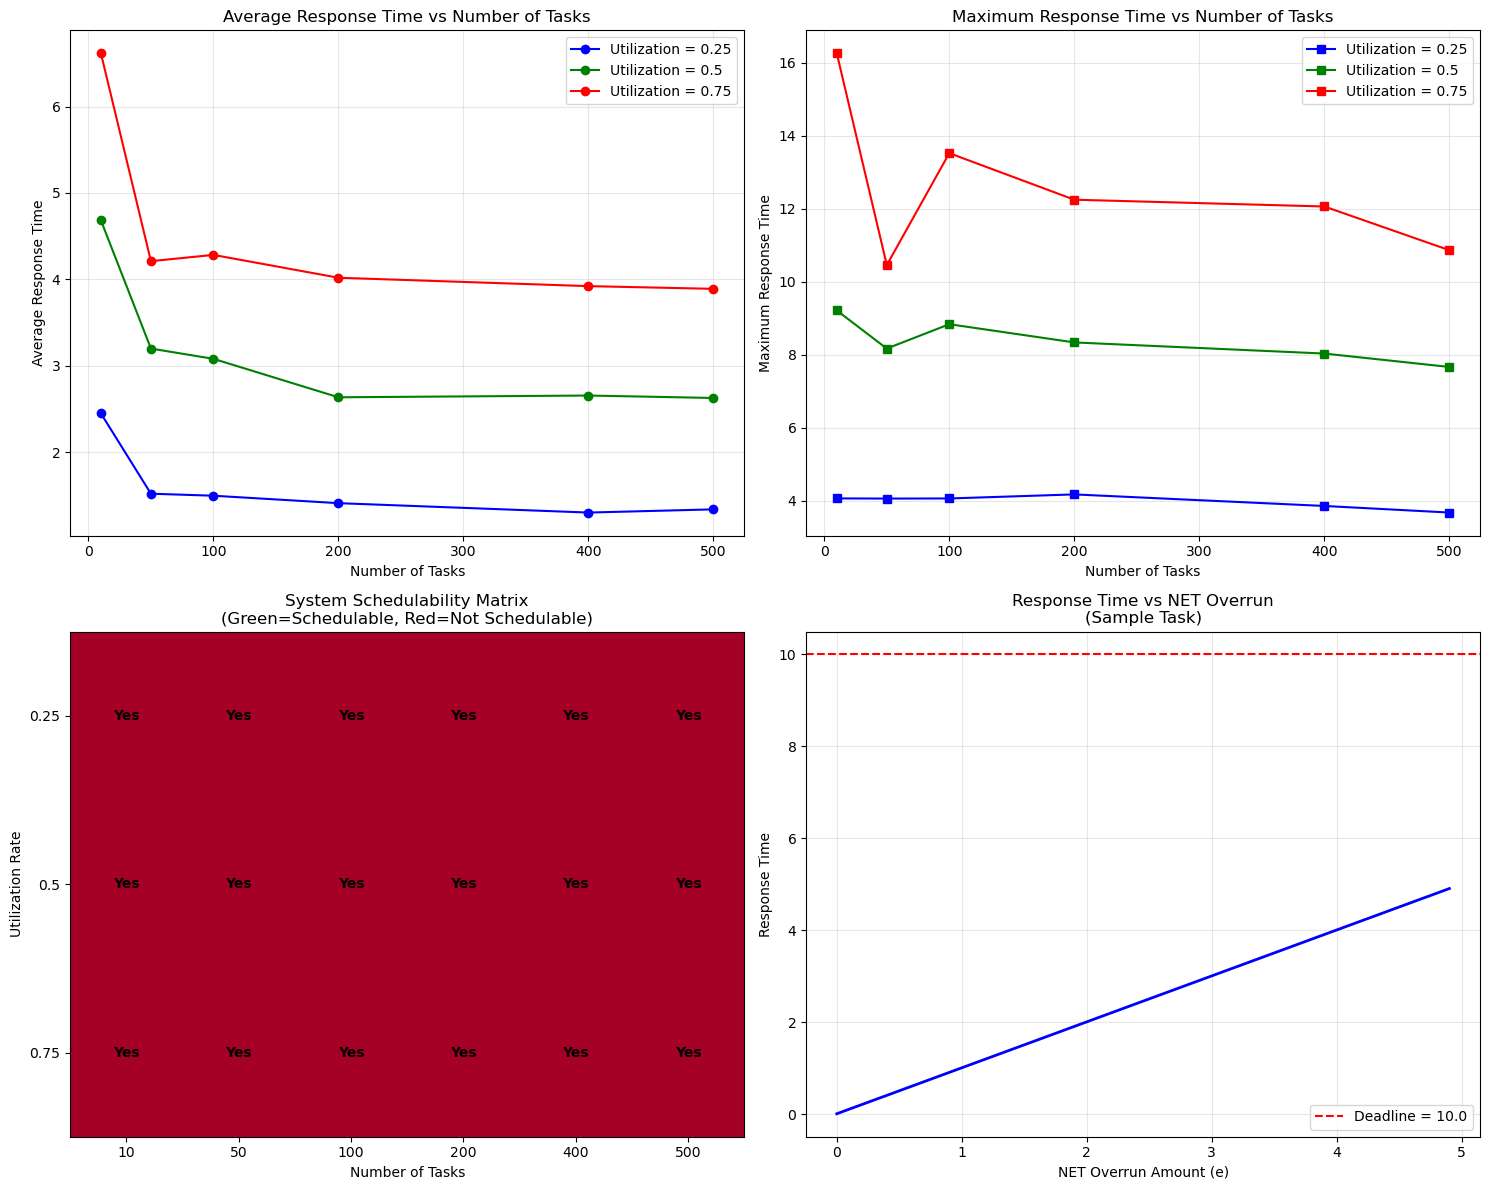


DETAILED REAL-TIME SYSTEM ANALYSIS RESULTS
System Configuration:
  - Scheduling Policy: Rate Monotonic
  - Scheduling Type: Preemptive
  - Scheduling Model: Partitioned
  - Number of Cores: 4

SUMMARY STATISTICS:
  - Total Configurations Tested: 18
  - Schedulable Configurations: 18
  - Schedulability Rate: 100.0%

DETAILED RESULTS BY CONFIGURATION:
--------------------------------------------------------------------------------
Configuration: 10 tasks, utilization = 0.25 (Partitioned Scheduling)
  Schedulable: True
  Average Response Time: 2.448
  Maximum Response Time: 4.058
  Core Load Distribution: [1, 3, 3, 3]
  Tasks with Critical Overrun Points: 0

Configuration: 10 tasks, utilization = 0.50 (Partitioned Scheduling)
  Schedulable: True
  Average Response Time: 4.684
  Maximum Response Time: 9.210
  Core Load Distribution: [1, 2, 3, 4]
  Tasks with Critical Overrun Points: 0

Configuration: 10 tasks, utilization = 0.75 (Partitioned Scheduling)
  Schedulable: True
  Average Respo

In [25]:
def main():
    print("Real-Time System NET Overrun Analysis")
    print("=" * 60)
    
    rt_system = RealTimeSystem(
        num_cores=4,
        scheduling_policy=SchedulingPolicy.RM,
        scheduling_type=SchedulingType.PREEMPTIVE,
        scheduling_model=SchedulingModel.PARTITIONED,
        task_allocation_policy=TaskAllocationPolicy.WFD
    )
    
    num_tasks_list = [10, 50, 100, 200, 400, 500]  
    utilization_rates = [0.25, 0.5, 0.75]          
    analysis_interferer_factor = 0.05

    results = rt_system.analyze_system_performance(num_tasks_list, utilization_rates, default_interferer_overrun_factor=analysis_interferer_factor)
    
    rt_system.generate_performance_graphs(results, 
        interferer_overrun_factor_for_graph=analysis_interferer_factor)
    
    rt_system.print_detailed_results(results)
    
    print("\nCRITICAL OVERRUN ANALYSIS EXAMPLE:")
    print("-" * 40)
    
    if rt_system.tasks:
        for i in range(min(3, len(rt_system.tasks))):
            critical_points = rt_system.find_critical_overrun_values(i, interferer_overrun_factor=analysis_interferer_factor)
            print(f"Task {i+1} (Period: {rt_system.tasks[i].period:.1f}, "
                  f"NET: {rt_system.tasks[i].net:.3f}):")
            if critical_points:
                print(f"  Found {len(critical_points)} critical overrun points:")
                for overrun, response_time in critical_points[:3]:  # Show first 3
                    print(f"    Overrun = {overrun:.2f} -> Response Time = {response_time:.3f}")
            else:
                print(f"  No critical overrun points found in tested range")
            print()

if __name__ == "__main__":
    main()